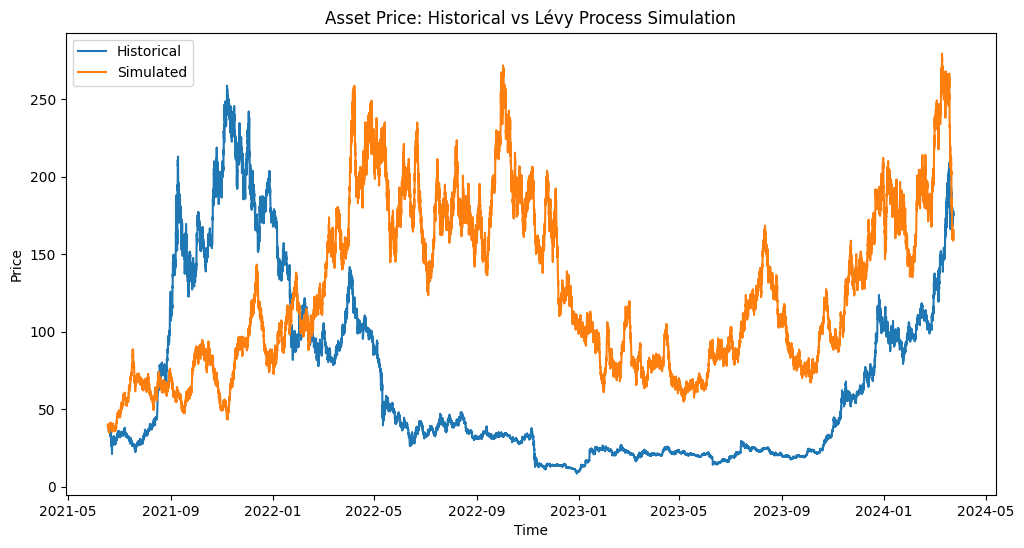

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import requests

data = pd.read_csv('../../Kraken_OHLCVT/SOLUSD_60.csv')

data.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'count']
data['time'] = pd.to_datetime(data['time'], unit='s')
data['close'] = data['close'].astype(float)
data['volume'] = data['volume'].astype(float)
data['count'] = data['count'].astype(float)
data['open'] = data['open'].astype(float)
data['high'] = data['high'].astype(float)
data['low'] = data['low'].astype(float)

df = data.dropna()

df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df = df.iloc[:-200]

# Calculate parameters
dt = (df['time'].diff().mean().total_seconds() / 86400)  # Time step in days
mu = df['log_returns'].mean() / dt  # Drift
sigma = df['log_returns'].std() / np.sqrt(dt)  # Volatility

# Estimate jump parameters (simple method)
threshold = 3 * sigma * np.sqrt(dt)  # Threshold for identifying jumps
jumps = df['log_returns'][abs(df['log_returns']) > threshold]
lambda_jump = len(jumps) / len(df)  # Jump intensity
jump_mean = jumps.mean()
jump_std = jumps.std()

def simulate_price_path(S0, T, N, mu, sigma, lambda_jump, jump_mean, jump_std):
    dt = T / N
    t = np.linspace(0, T, N)  # Changed N+1 to N
    
    # Brownian motion component
    dW = np.random.normal(0, np.sqrt(dt), N-1)  # Changed N to N-1
    
    # Jump component
    dN = np.random.poisson(lambda_jump * dt, N-1)  # Changed N to N-1
    J = np.random.normal(jump_mean, jump_std, N-1)  # Changed N to N-1
    
    # Combine components
    S = np.zeros(N)
    S[0] = S0
    for i in range(1, N):
        dS = S[i-1] * (mu * dt + sigma * dW[i-1] + J[i-1] * dN[i-1])
        S[i] = S[i-1] + dS
    
    return t, S

# Simulation parameters
S0 = df['close'].iloc[0]
T = (df['time'].iloc[-1] - df['time'].iloc[0]).total_seconds() / 86400  # Total time in days
N = len(df)

# Run simulation
t_sim, S_sim = simulate_price_path(S0, T, N, mu, sigma, lambda_jump, jump_mean, jump_std)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['close'], label='Historical')
plt.plot(df['time'], S_sim, label='Simulated')  # Now S_sim should have the same length as df['time']
plt.legend()
plt.title('Asset Price: Historical vs Lévy Process Simulation')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()